C:\Users\Brick\miniconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: All-NaN slice encountered
C:\Users\Brick\miniconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Brick\miniconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


0

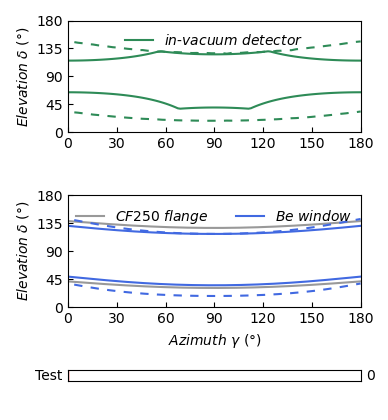

In [1]:
%matplotlib widget
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.linalg import det
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

### functions for rectangle intersections
def rotate_detector_2d(l=80, b=40, e_det=10, beta=0):
    """rotates the detector around the center of the flange by beta, where the long detector axis is along x for beta = 0"""
    e1 = np.array([b/2,  l/2+e_det, 0])
    e2 = np.array([-b/2, l/2+e_det, 0])
    e3 = np.array([-b/2, -l/2+e_det, 0])
    e4 = np.array([b/2,  -l/2+e_det, 0])
    r_beta = Rotation.from_euler('z', [beta], degrees=False)
    e1,e2,e3,e4 = r_beta.apply([e1,e2,e3,e4])
    return np.array([e1[:2],e2[:2],e3[:2],e4[:2]])

def radii_rectangle(l=80, b=40, e_det=10, e_sample=np.array([0,46]), gam=np.array([0]), beta=0):
    """calculates the distance between sample and the intersection points of the detector projected onto the x-z pllane for given beta and gamma angles"""

    gam = -gam
    s = e_sample
    s1 = np.zeros((len(gam),2,2)) + s

    s1[:,0,0] = s1[:,0,0] -250*np.array(np.cos(gam))
    s1[:,0,1] = s1[:,0,1] +250*np.array(np.sin(gam))
    s1[:,1,0] = s1[:,1,0] +250*np.array(np.cos(gam))
    s1[:,1,1] = s1[:,1,1] -250*np.array(np.sin(gam))
    
    e1,e2,e3,e4 = rotate_detector_2d(l=l, b=b, e_det=e_det, beta=beta)
    es = np.array([[e1,e2], [e1,e4], [e2,e3], [e3,e4]])
    M = np.array( [np.array([np.divide( det([p1-p3,p3-p4]),det([p1-p2,p3-p4])) for p3, p4 in zip(s1[:,0],s1[:,1]) ]) for p1,p2 in es])
    M[~((M<1.)&(M>0.))] = np.nan
    
    p1s = es[:,0]
    p2s = es[:,1]
    intersects = np.array([m[:,None]*(p2s-p1s)+p1s for m in M.T])
    radii_2d = np.linalg.norm(intersects-s, axis=2)*(intersects-s)[:,:,1]/-abs((intersects-s)[:,:,1])
    radii_2d = np.array([np.nanmax(radii_2d, axis=1), np.nanmin(radii_2d, axis=1)])
    
    return radii_2d

### functions for circle intersections
def radii(gamma, x0, y0, r):
    '''calculates the two intersections of a line from the origin with the circle defining the window'''
    r1 = np.cos(gamma)*x0+np.sin(gamma)*y0 + np.sqrt((np.cos(gamma)*x0+np.sin(gamma)*y0)**2  -(x0**2+y0**2-r**2))
    r2 = np.cos(gamma)*x0+np.sin(gamma)*y0 - np.sqrt((np.cos(gamma)*x0+np.sin(gamma)*y0)**2  -(x0**2+y0**2-r**2))
    return (r1,r2)

def excentricity(beta, e_window, e_sample=[0,-46]):
    '''calculates the excentricity of the circle defining the window for different top flange rotations'''
    x0 = np.cos(beta)*e_window - e_sample[0]
    y0 = np.sin(beta)*e_window - e_sample[1]
    return x0, y0

def phi(r, h):
    '''
    Returns the scatter angle measured from the vertical of r with height above the sample,h.
    '''
    return np.arctan(r/h)

def delta_from_beta(beta, gamma, r, e_window, e_sample, h):
    x0,y0 = excentricity(beta, e_window, e_sample)
    radiis = radii(gamma, x0, y0,r)
    deltas = [90-np.rad2deg(phi(radiius, h)) for radiius in radiis]
    return deltas

def circle(beta, e_window, e_sample, r):
    '''calculates the excentricity of the circle defining the window for different top flange rotations'''
    x0,y0 = excentricity(beta, e_window, e_sample)
    phi = np.linspace(0, 2*np.pi, 3601, endpoint=True)
    x = r * np.cos(phi) - x0
    y = r * np.sin(phi) - y0
    return x, y

'''In-vacuum detector - scattering angles 1 position'''
gamma_invac = np.linspace(0.001, np.pi+0.001, 121, endpoint=True)
h_invac = 42
l_invac = 80
b_invac = 40
e_invac = 36
e_sample_invac = np.array([0,46])
beta=np.deg2rad(0)
radii_2d = radii_rectangle(l=l_invac, b=b_invac, e_det=e_invac, e_sample=e_sample_invac, gam=gamma_invac, beta=beta )
deltamin, deltamax = [90-np.rad2deg(phi(radii_2d[0], h_invac)),90-np.rad2deg(phi(radii_2d[1], h_invac))]
#source_invac = ColumnDataSource(data=dict(x=np.rad2deg(gamma_invac), y1=deltamin, y2 = deltamax))
source_invac = dict(x=np.rad2deg(gamma_invac), y1=deltamin, y2 = deltamax)
rect_edges_invac = rotate_detector_2d(l=l_invac, b=b_invac, e_det=e_invac, beta=beta) - e_sample_invac
rect_edges_invac = np.vstack([rect_edges_invac,rect_edges_invac[0]])
#source_invac_rect = ColumnDataSource(data=dict(x=rect_edges_invac.T[0], y=rect_edges_invac.T[1]))
source_invac_rect = dict(x=rect_edges_invac.T[0], y=rect_edges_invac.T[1])

'''In-vacuum detector - scattering angles cumulative all position'''
betas = np.linspace(0,2*np.pi, 60)
gammas = np.linspace(0.001,np.pi+0.001, 60)
radii_2d = np.array([radii_rectangle(l=l_invac, b=b_invac, e_det=e_invac, e_sample=e_sample_invac, gam=gammas, beta=beta ) for beta in betas])
rs = np.array([np.nanmax(radii_2d, axis=(0,1)), np.nanmin(radii_2d, axis=(0,1))])
deltamin, deltamax = [90-np.rad2deg(phi(rs[0], h_invac)),90-np.rad2deg(phi(rs[1], h_invac))]
#source_invac_full_betas = ColumnDataSource(data=dict(x=np.rad2deg(gammas), y1=deltamin, y2 = deltamax))
source_invac_full_betas = dict(x=np.rad2deg(gammas), y1=deltamin, y2 = deltamax)


'''Beryllium window - scattering angles 1 position'''
gamma = np.linspace(0, np.pi, 361, endpoint=True)
h = 36
r = 70/2
e_window = 30
e_sample = [0,-46]
beta=0
deltamin, deltamax = delta_from_beta(np.deg2rad(beta-90), gamma, r, e_window, e_sample, h)
#source_window = ColumnDataSource(data=dict(x=np.rad2deg(gamma), y1=deltamin, y2 = deltamax))
source_window = dict(x=np.rad2deg(gamma), y1=deltamin, y2 = deltamax)

x,y = circle(np.deg2rad(beta-90), e_window, e_sample, r)
source_window_circle = dict(x=x, y=y)

'''Be window - scattering angles cumulative all position'''
betas = np.linspace(0,2*np.pi, 360)
delta_from_beta(np.deg2rad(0), gamma, r, e_window, e_sample, h)
ds = np.array([delta_from_beta(beta, gamma, r, e_window, e_sample, h) for beta in betas])
dmins =  np.array([np.nanmin(dmin) for dmin in ds[:,0,:].T])
dmaxs = np.array([np.nanmax(dmax) for dmax in ds[:,1,:].T])
#source_window_full_betas = ColumnDataSource(data=dict(x=np.rad2deg(gamma), y1=dmins, y2 = dmaxs))
source_window_full_betas = dict(x=np.rad2deg(gamma), y1=dmins, y2 = dmaxs)


'''Top flange - scattering angles'''
h_t = 102
r_t = 248.5/2
e_window_t = 0
deltamin_t, deltamax_t = delta_from_beta(0, gamma, r_t, e_window_t, e_sample, h_t)
#source_top_flange = ColumnDataSource(data=dict(x=np.rad2deg(gamma), y1=deltamin_t, y2 = deltamax_t))
source_top_flange = dict(x=np.rad2deg(gamma), y1=deltamin_t, y2 = deltamax_t)

x,y = circle(0, e_window_t, e_sample, r_t)
#source_top_flange_circle = ColumnDataSource(data=dict(x=x, y=y))
source_top_flange_circle = data=dict(x=x, y=y)


#g = plt.figure(title='Geometry')
#imgurl = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=3360&y=1040&a=true&file=Be_window9.JPG&t=WgAa3cg9sgVJFZK&scalingup=0'

#g.image_url(url=[imgurl], x=-166, y=-203, w=330, h=350, anchor="bottom_left")
#g.line('x', 'y', source=source_invac_rect, line_width=5, line_color = 'green', legend_label="In-vacuum det")
#g.line('x', 'y', source=source_window_circle, line_width=5, line_color = 'royalblue', legend_label="Be window")
#g.line('x', 'y', source=source_top_flange_circle, line_width=5, line_color = 'grey')
#g.circle(x=0, y=0, size=10,fill_color="orange", line_color = 'black', legend_label="Sample")
#g.y_range=Range1d(-205, 145)
#g.x_range=Range1d(-165, 165)
#g.title.align='center'



def update_plot(new):
    new = slider.val
    beta = new-90
    deltamin, deltamax = delta_from_beta(np.deg2rad(beta), gamma, r, e_window, e_sample, h)
    source_window = dict(x=np.rad2deg(gamma), y1=deltamin, y2 = deltamax)
    
    radii_2d = radii_rectangle(l=l_invac, b=b_invac, e_det=e_invac, e_sample=e_sample_invac, gam=gamma_invac, beta=np.deg2rad(new) )
    deltamin, deltamax = [90-np.rad2deg(phi(radii_2d[0], h_invac)),90-np.rad2deg(phi(radii_2d[1], h_invac))]
    source_invac = dict(x=np.rad2deg(gamma_invac), y1=deltamin, y2 = deltamax)
    invac_y1.set_ydata(source_invac["y1"])
    invac_y2.set_ydata(source_invac["y2"])
    #invac_fill.remove()
    window_y1.set_ydata(source_window["y1"])
    window_y2.set_ydata(source_window["y2"])
    
    #invac_fill = ax[0].fill_between(source_invac['x'],source_invac['y2'], source_invac['y1'], color='seagreen', alpha=0.2)

    rect_edges_invac = rotate_detector_2d(l=l_invac, b=b_invac, e_det=e_invac, beta=np.deg2rad(new)) - e_sample_invac
    rect_edges_invac = np.vstack([rect_edges_invac,rect_edges_invac[0]])
    source_invac_rect = dict(x=rect_edges_invac.T[0], y=rect_edges_invac.T[1])
    
    x,y = circle(np.deg2rad(beta), e_window, e_sample, r)
    source_window_circle = dict(x=x, y=y)
    fig.canvas.draw_idle()

    #p.line('x', 'y', source=source, line_width=3, line_alpha=0.6)
    #push_notebook()

fig, ax = plt.subplots(3,1,gridspec_kw={"height_ratios":[1,1,0.1]}, figsize=(5*0.35/0.45,4.2))
ax[1].sharex(ax[0])
t = np.arange(0,361,15)


invac_y1, = ax[0].plot(source_invac['x'], source_invac['y1'], color='seagreen', label='$in$-$vacuum$ $detector$')
invac_y2, = ax[0].plot(source_invac['x'], source_invac['y2'], color='seagreen')
ax[0].plot(source_invac_full_betas['x'], source_invac_full_betas['y1'], color='seagreen', linestyle=(5,(4,4)))
ax[0].plot(source_invac_full_betas['x'], source_invac_full_betas['y2'], color='seagreen', linestyle=(5,(4,4)))
#ax[0].fill_between(source_invac['x'],source_invac['y2'], source_invac['y1'], color='seagreen', alpha=0.2)

ax[1].plot(source_top_flange['x'], source_top_flange['y1'], color='grey', label='$CF250$ $flange$', alpha=0.8)
ax[1].plot(source_top_flange['x'], source_top_flange['y2'], color='grey', alpha=0.8)
window_y1, = ax[1].plot(source_window['x'], source_window['y1'], color='royalblue', label='$Be$ $window$')
window_y2, = ax[1].plot(source_window['x'], source_window['y2'], color='royalblue')
ax[1].plot(source_window_full_betas['x'], source_window_full_betas['y1'], color='royalblue', linestyle=(5,(4,4)))
ax[1].plot(source_window_full_betas['x'], source_window_full_betas['y2'], color='royalblue', linestyle=(5,(4,4)))
#ax[1].fill_between(source_window['x'],source_window['y2'], source_window['y1'], color='royalblue', alpha=0.2)


ax[0].set_ylabel(r'$Elevation$ $\delta$ $(°)$')
ax[1].set_ylabel(r'$Elevation$ $\delta$ $(°)$')
ax[1].set_xlabel(r'$Azimuth$ $\gamma$ $(°)$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,180)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,180)
ax[0].legend(frameon=False, loc='upper center')
ax[1].legend(frameon=False, loc='upper center', ncol=2)
ax[0].tick_params(direction='in')
ax[0].tick_params(direction='in')
ax[1].tick_params(direction='in')
ax[1].tick_params(direction='in')
ax[0].set_xticks([0,30,60,90,120,150,180])
ax[0].set_yticks([0,45,90,135,180])
ax[1].set_yticks([0,45,90,135,180])

fig.tight_layout()

#fig.savefig('accessible_angles.pdf')


## matplotlib
slider = Slider(
    ax=ax[-1],
    label='Test',
    valmin=0,
    valmax=360,
    valinit=0,
)
slider.on_changed(update_plot)

## ipywidgets
#slider = widgets.IntSlider(
#value=0,
#    min=0,
#    max=360,
#    step=15,
#    description='Test:',
#    disabled=False,
#    continuous_update=False,
#    orientation='horizontal',
#    readout=True,
#    readout_format='d'
#)
#from ipywidgets import interact
#interact(update_plot, new=slider);


In [2]:
import session_info

In [3]:
session_info.show()

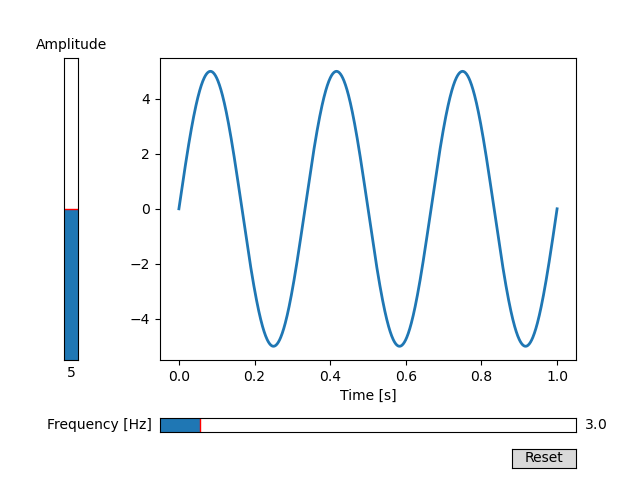

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

In [ ]:
slider.

In [3]:
np.arange(0,361,15)

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360])

In [6]:
import pylab as plt2


In [9]:
fig, ax = plt2.subplots(2,1, sharex=True, figsize=(5*0.35/0.45,4.2))
ax[0].plot(source_invac['x'], source_invac['y1'], color='seagreen', label='$in$-$vacuum$ $detector$')
ax[0].plot(source_invac['x'], source_invac['y2'], color='seagreen')
ax[0].plot(source_invac_full_betas['x'], source_invac_full_betas['y1'], color='seagreen', linestyle=(5,(4,4)))
ax[0].plot(source_invac_full_betas['x'], source_invac_full_betas['y2'], color='seagreen', linestyle=(5,(4,4)))
ax[0].fill_between(source_invac['x'],source_invac['y2'], source_invac['y1'], color='seagreen', alpha=0.2)

ax[1].plot(source_top_flange['x'], source_top_flange['y1'], color='grey', label='$CF250$ $flange$', alpha=0.8)
ax[1].plot(source_top_flange['x'], source_top_flange['y2'], color='grey', alpha=0.8)
ax[1].plot(source_window['x'], source_window['y1'], color='royalblue', label='$Be$ $window$')
ax[1].plot(source_window['x'], source_window['y2'], color='royalblue')
ax[1].plot(source_window_full_betas['x'], source_window_full_betas['y1'], color='royalblue', linestyle=(5,(4,4)))
ax[1].plot(source_window_full_betas['x'], source_window_full_betas['y2'], color='royalblue', linestyle=(5,(4,4)))
ax[1].fill_between(source_window['x'],source_window['y2'], source_window['y1'], color='royalblue', alpha=0.2)


ax[0].set_ylabel(r'$Elevation$ $\delta$ $(°)$')
ax[1].set_ylabel(r'$Elevation$ $\delta$ $(°)$')
ax[1].set_xlabel(r'$Azimuth$ $\gamma$ $(°)$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,180)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,180)
ax[0].legend(frameon=False, loc='upper center')
ax[1].legend(frameon=False, loc='upper center', ncol=2)
ax[0].tick_params(direction='in')
ax[0].tick_params(direction='in')
ax[1].tick_params(direction='in')
ax[1].tick_params(direction='in')
ax[0].set_xticks([0,30,60,90,120,150,180])
ax[0].set_yticks([0,45,90,135,180])
ax[1].set_yticks([0,45,90,135,180])

fig.tight_layout()
#fig.savefig('accessible_angles.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Resolution

In [2]:
def calc_resolution(h,r,px,energy=2000):
    delta1 =np.pi/2- np.arctan(r/h)
    #px = px * np.cos(np.pi/2-delta1)
    #print('px', px)

    delta2 = np.pi/2-np.arctan((r-px)/h)

    d_delta = abs(delta1-delta2)
    #print('deltas', delta1, delta2, d_delta)

    wavelength = 1.24e-6/energy*1e9
    #print(energy, wavelength)
    d_q = 4*np.pi*np.sin((delta1)/2)/wavelength - 4*np.pi*np.sin((delta2)/2)/wavelength
    return [d_delta, d_q]


In [3]:


#fixed
h = 45
px = 75e-3
res, res_q = np.array([calc_resolution(h=h,r=0,px=px, energy=2000), calc_resolution(h=h,r=np.max(rs),px=px, energy=2000)]).T
res, res_q5 = np.array([calc_resolution(h=h,r=0,px=px, energy=5000), calc_resolution(h=h,r=np.max(rs),px=px, energy=5000)]).T

print(f'Angular resolution fixed invac is ({res[1]*1e3:.3} - {res[0]*1e3:.3})mrad')
print(f'q resolution fixed invac @2keV is ({res_q[1]:.3} - {res_q[0]:.3})nm-1')
print(f'q resolution fixed invac @5keV is ({res_q5[1]:.3} - {res_q5[0]:.3})nm-1')
#motorized

h = 245
px = 75e-3
res, res_q = np.array([calc_resolution(h=h,r=0,px=px, energy=2000), calc_resolution(h=h,r=40,px=px, energy=2000)]).T
res, res_q5 = np.array([calc_resolution(h=h,r=0,px=px, energy=5000), calc_resolution(h=h,r=40,px=px, energy=5000)]).T

print(f'Angular resolution mot invac is ({res[1]*1e3:.3} - {res[0]*1e3:.3})mrad')
print(f'q resolution  mot invac @2keV is ({res_q[1]:.3} - {res_q[0]:.3})nm-1')
print(f'q resolution  mot invac @5keV is ({res_q5[1]:.3} - {res_q5[0]:.3})nm-1')

Angular resolution fixed invac is (0.194 - 1.67)mrad
q resolution fixed invac @2keV is (-0.00193 - -0.0119)nm-1
q resolution fixed invac @5keV is (-0.00483 - -0.0298)nm-1
Angular resolution mot invac is (0.298 - 0.306)mrad
q resolution  mot invac @2keV is (-0.0023 - -0.00219)nm-1
q resolution  mot invac @5keV is (-0.00576 - -0.00548)nm-1


In [202]:
x = np.linspace(0,np.max(rs), 500)
y,n = calc_resolution(h=45,r=x,px=px)

[1.57079633 1.56526692 1.55973786 1.55420947 1.54868209 1.54315607
 1.53763173 1.53210942 1.52658947 1.52107221 1.51555798 1.51004711
 1.50453993 1.49903678 1.49353797 1.48804384 1.48255472 1.47707092
 1.47159277 1.46612058 1.46065469 1.45519539 1.449743   1.44429784
 1.4388602  1.43343041 1.42800875 1.42259553 1.41719105 1.41179559
 1.40640946 1.40103293 1.3956663  1.39030984 1.38496382 1.37962854
 1.37430424 1.36899121 1.36368971 1.35839999 1.35312231 1.34785692
 1.34260408 1.33736401 1.33213698 1.3269232  1.32172292 1.31653635
 1.31136374 1.30620528 1.30106121 1.29593172 1.29081703 1.28571734
 1.28063285 1.27556375 1.27051023 1.26547248 1.26045067 1.25544499
 1.2504556  1.24548268 1.24052639 1.23558688 1.2306643  1.22575883
 1.22087058 1.21599972 1.21114637 1.20631067 1.20149275 1.19669273
 1.19191074 1.18714688 1.18240127 1.17767402 1.17296524 1.16827501
 1.16360345 1.15895063 1.15431665 1.14970159 1.14510553 1.14052855
 1.13597071 1.1314321  1.12691276 1.12241276 1.11793216 1.1134

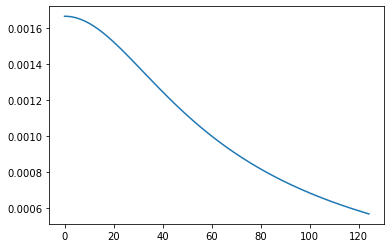

In [203]:
import pylab as pyplt
pyplt.figure()
pyplt.plot(x,y)

In [204]:
1.67/5

0.33399999999999996